In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0

import os
from PIL import Image
from google.colab import files

In [2]:
current_directory = os.getcwd()
current_directory

'/content'

In [3]:
dataset_name = "fashion_mnist"
_, ds_info = tfds.load(
    dataset_name,
    data_dir = current_directory,
    split = "train",
    with_info=True,
    as_supervised=True,
    #batch_size = batch_size,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /content/fashion_mnist/incomplete.HC1AZE_3.0.1/fashion_mnist-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /content/fashion_mnist/incomplete.HC1AZE_3.0.1/fashion_mnist-test.tfrecord*...:   0%|          | 0/1…

Dataset fashion_mnist downloaded and prepared to /content/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [7]:
import h5py
f = h5py.File("model.h5", "r")
# Imprime los nombres de los grupos o datasets para ver cuántas capas se guardaron
print(list(f.keys()))
f.close()


['model_weights', 'optimizer_weights']


In [15]:
IMG_SIZE = 28
BATCH_SIZE = 32

def build_model(num_classes=10):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    base_model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.4  # Adjust dropout rate
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Add regularizer
    x = layers.Dropout(0.3)(x)  # Add dropout after dense layer
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-4)  # Adjust learning rate
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

model = build_model()
model.load_weights('model.h5')

Saving 41OuKMk0BFL._AC_SX466_.jpg to 41OuKMk0BFL._AC_SX466_.jpg


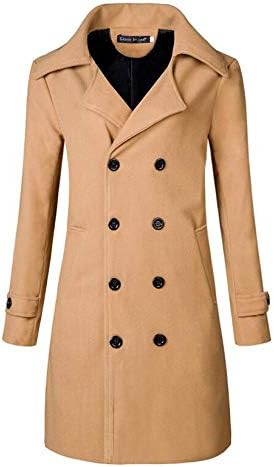

In [26]:
image_file = files.upload()

for filename, content in image_file.items():

    with open(filename, 'wb') as f:
        f.write(content)

    sample = Image.open(filename)

sample

In [27]:
size = (IMG_SIZE, IMG_SIZE)
sample = tf.image.resize(sample, size)
sample = tf.expand_dims(sample, 0)

prediction = model.predict(sample)

label_info = ds_info.features["label"]

for i in range(5):
  print(f"Es un {label_info.int2str(np.argsort(prediction)[0][-(i+1)])} con una probabilidad de: {np.sort(prediction)[0][-(i+1)]:2f}")

1/1 [==============================] - 0s 30ms/step
Es un Bag con una probabilidad de: 0.747797
Es un Shirt con una probabilidad de: 0.155804
Es un Coat con una probabilidad de: 0.037435
Es un Pullover con una probabilidad de: 0.021719
Es un Dress con una probabilidad de: 0.020319
